In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# увеличим количество отображаемых столбцов
pd.set_option("display.max_columns", None)
# увеличим количество отображаемых рядов
pd.set_option("display.max_rows", 500)
# увеличим ширину столбцов
pd.options.display.max_colwidth = 250

# отключаем экспоненциальное представление
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import numpy as np


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial import Voronoi
from scipy.spatial.distance import squareform

from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

from tqdm.autonotebook import tqdm

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

/var/folders/vx/d70k_j2d49q255qhb_42b9h80000gn/T/ipykernel_34354/3729015266.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Кластеризация профилей добычи

In [2]:
# Define the path to the data file
path = "data/data.txt"

# Load the data file into a pandas DataFrame. The delimiter is set to tab character as the file is a TSV (Tab-separated values) file
df = pd.read_csv(path, delimiter="\t")

# Convert all column names to lower case to maintain consistency and ease of access
df.columns = [x.lower() for x in df.columns]

# Replace any occurrence of the string "well" in the 'well' column with an empty string and convert the values to lower case
df["well"] = df["well"].str.lower().str.replace("well", "")

# Convert the 'date' column to datetime format for easier manipulation in future operations
df["date"] = pd.to_datetime(df["date"])

# Display the first 5 rows of the DataFrame for a quick overview of the data
df.head()

,date,well,qoil,qwat,qgas,bhp
0,2011-02-01,1,7946.07,34.68,NaN,2236.95
1,2011-03-04,1,8196.89,34.68,NaN,2236.95
2,2011-04-04,1,7888.97,34.68,NaN,2236.95
3,2011-05-05,1,8040.34,29.39,NaN,2236.95
4,2011-06-05,1,8206.16,9.31,NaN,2236.95


In [ ]:
# This block of code operates on a DataFrame named 'df' which contains data about wells.

# Count the total number of unique wells in the DataFrame
print(len(df["well"].unique()))

# Output the names of the unique wells
print(df["well"].unique())

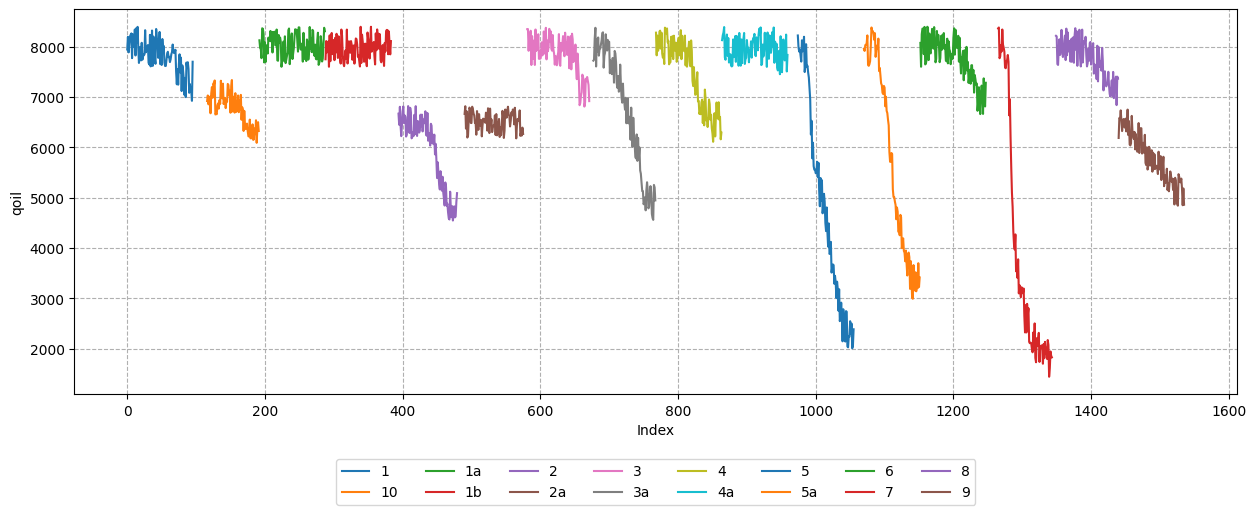

In [4]:
# 'qoil' is the column we're interested in plotting
column = "qoil"

# Create a new figure with specified size
plt.figure(figsize=(15, 5))

# Loop over each unique well in the dataframe
for i, col in enumerate(df["well"].unique()):
    # Plot the 'qoil' values for the current well
    plt.plot(df[df["well"] == col][column], label=col)

# Set up a legend to identify the wells in the plot
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.15), ncol=8)

# Add a grid to the plot with dashed lines (ls="--")
plt.grid(ls="--")

plt.xlabel("Index")

plt.ylabel(column)

plt.show()

In [6]:
df.head(1)

,date,well,qoil,qwat,qgas,bhp
0,2011-02-01,1,7946.07,34.68,NaN,2236.95


In [5]:
# Defines the column name that we are interested in
column = "qoil"

# Pivots the DataFrame to create a new DataFrame
# The new DataFrame has "date" as its index, "well" as its columns, and the values of the specified "column" as its values
# The 'fillna' method is used to fill any NA/NaN values using the 'bfill' method, which propagates the next valid observation backward to the previous valid
data = df.pivot_table(index="date", columns="well", values=column).fillna(
    method="bfill"
)

data.head()

/var/folders/vx/d70k_j2d49q255qhb_42b9h80000gn/T/ipykernel_34354/313627358.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.pivot_table(index="date", columns="well", values=column).fillna(


well,1,10,1a,1b,2,2a,3,3a,4,4a,5,5a,6,7,8,9
date,,,,,,,,,,,,,,,,
2011-02-01,7946.07,6921.82,8128.74,7751.56,6669.88,6665.43,8350.88,7724.35,8280.55,8131.83,8224.81,7957.19,8076.50,8364.20,8218.09,6187.07
2011-03-04,8196.89,6921.82,7977.84,8113.30,6669.88,6665.43,8350.88,7724.35,7829.82,8230.25,8224.81,7957.19,7603.10,8364.20,8218.09,6584.08
2011-04-04,7888.97,6921.82,7951.10,7889.25,6669.88,6665.43,8350.88,7724.35,8223.48,8283.06,8224.81,7957.19,8249.14,8364.20,8218.09,6567.63
2011-05-05,8040.34,6921.82,7773.60,7939.94,6669.88,6665.43,8350.88,7724.35,7920.41,8391.88,8224.81,7957.19,8361.10,8364.20,8218.09,6735.78
2011-06-05,8206.16,6921.82,8367.57,8102.22,6669.88,6665.43,8350.88,7724.35,7983.92,7788.66,8224.81,7957.19,8361.20,8364.20,8218.09,6520.98


Визуализируем профили добычи

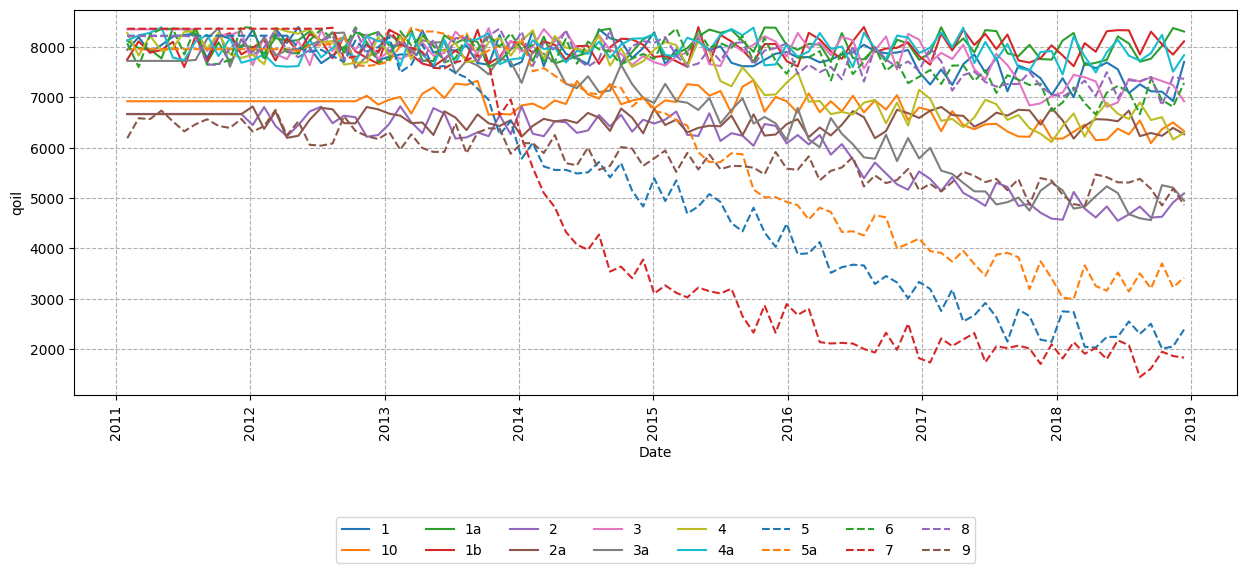

In [7]:
# Define a list of line styles for the plot
ls = [
    "-",
    "-",
    "-",
    "-",
    "-",
    "-",
    "-",
    "-",
    "-",
    "-",
    "--",
    "--",
    "--",
    "--",
    "--",
    "--",
    "--",
    "--",
    "--",
]

plt.figure(figsize=(15, 5))

# Loop over each column in the dataframe
for i, col in enumerate(data.columns):
    # For each column, plot the data with the corresponding line style
    plt.plot(data[col], label=col, ls=ls[i])

# Add a legend to the plot, located at the upper center outside the plot area
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

# Add a grid to the plot with a dashed line style
plt.grid(ls="--")

plt.xlabel("Date")
plt.ylabel(column)
plt.xticks(rotation=90)
plt.show()

In [8]:
# Instantiate StandardScaler, a preprocessing module that standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Make a copy of the original DataFrame to avoid changing the original data
data_scaled = data.copy()

# Compute the mean and standard deviation based on the training data
scaler.fit(data_scaled)

# Perform standardization by centering and scaling
data_scaled[data_scaled.columns] = scaler.transform(data_scaled)

data_scaled.head()

well,1,10,1a,1b,2,2a,3,3a,4,4a,5,5a,6,7,8,9
date,,,,,,,,,,,,,,,,
2011-02-01,0.43,0.41,0.44,-1.01,0.94,0.74,1.25,0.83,1.23,0.72,1.33,1.00,0.74,1.36,1.16,0.80
2011-03-04,1.19,0.41,-0.21,0.62,0.94,0.74,1.25,0.83,0.57,1.13,1.33,1.00,-0.34,1.36,1.16,1.61
2011-04-04,0.26,0.41,-0.33,-0.39,0.94,0.74,1.25,0.83,1.15,1.34,1.33,1.00,1.14,1.36,1.16,1.57
2011-05-05,0.72,0.41,-1.10,-0.16,0.94,0.74,1.25,0.83,0.70,1.79,1.33,1.00,1.39,1.36,1.16,1.91
2011-06-05,1.22,0.41,1.48,0.57,0.94,0.74,1.25,0.83,0.80,-0.70,1.33,1.00,1.39,1.36,1.16,1.48


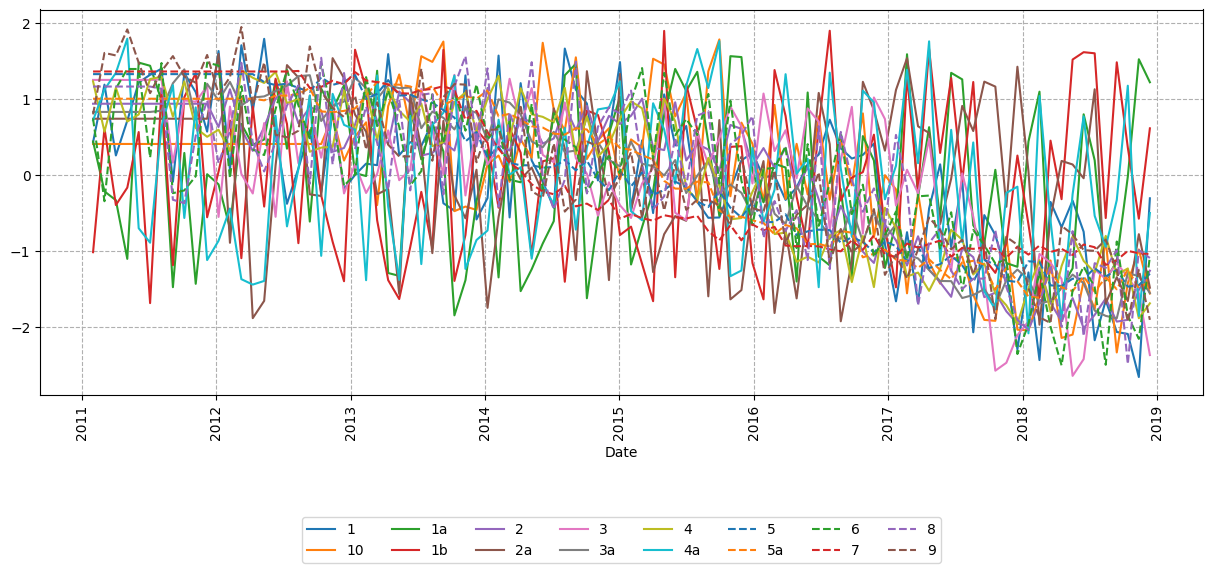

In [9]:
plt.figure(figsize=(15, 5))

for i, col in enumerate(data_scaled.columns):
    plt.plot(data_scaled.index, data_scaled[col], label=col, linestyle=ls[i])

leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.3), ncol=8)

plt.grid(ls="--")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

- Можете ли мы выделить скважины которые по вашей "экспертной" оценке попадают в отдельные кластера?
- На какие свойства профилей вы опирались при определении кластеров?
<br>
<br>
Порстроение кластермапа

  0%|          | 0/9 [00:00<?, ?it/s]/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
 11%|█         | 1/9 [00:00<00:06,  1.32it/s]/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
 33%|███▎      | 3/9 [00:00<00:01,  4.17it/s]/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py

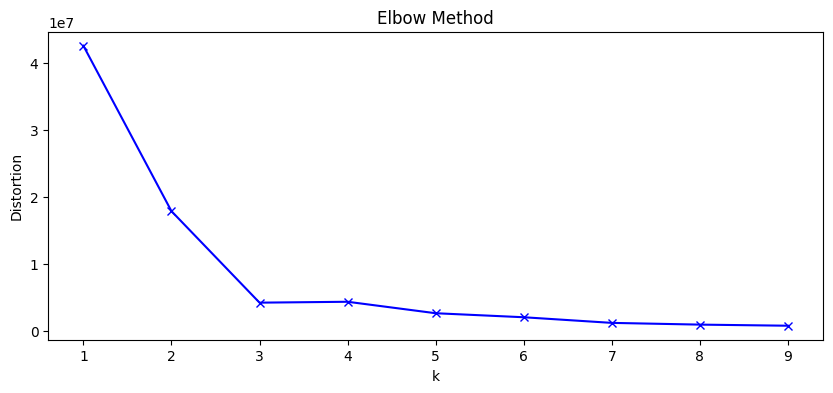

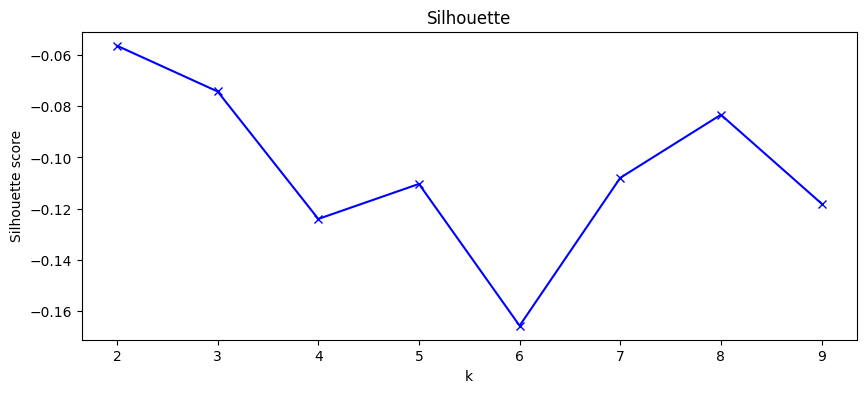

In [10]:
# Initialize empty lists to store distortions and silhouette scores
distortions = []
silhouette = []

# Specify the range of 'k' values we want to test (number of clusters)
n = range(1, 10)

# Loop over each 'k' value
for k in tqdm(n):
    # Initialize a TimeSeriesKMeans model
    model = TimeSeriesKMeans(
        n_clusters=k,  # number of clusters
        metric="dtw",  # use dynamic time warping distance
        n_jobs=1,  # number of parallel jobs
        max_iter=10,  # maximum number of iterations
        random_state=0,  # random state for reproducibility
    )
    # Fit the model to the data
    model.fit(data.T)
    # Calculate and append the model's inertia (sum of squared distances of samples to their closest cluster center)
    distortions.append(model.inertia_)

    # Calculate and append silhouette score (measure of how similar an object is to its own cluster compared to other clusters)
    # for k > 1, since silhouette score is not defined for a single cluster
    if k > 1:
        silhouette.append(silhouette_score(data_scaled.T, model.labels_))

# Plot the distortions as a function of 'k'
plt.figure(figsize=(10, 4))
plt.plot(n, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("Elbow Method")
plt.show()

# Plot the silhouette scores as a function of 'k'
plt.figure(figsize=(10, 4))
plt.plot(n[1:], silhouette, "bx-")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette")
plt.show()

In [11]:
# Number of clusters to be generated
n_clusters = 3

# Initialize the Time Series K-Means model
# n_clusters: the number of clusters to form
# metric: the distance metric to be used, in this case, Dynamic Time Warping (DTW)
# n_jobs: the number of CPU cores to use for computation, 1 means use one core (consider setting to -1 for using all cores)
# max_iter: maximum number of iterations of the k-means algorithm for a single run
# random_state: determines random number generation for centroid initialization, using an int will guarantee the same results across different calls
model = TimeSeriesKMeans(
    n_clusters=n_clusters, metric="dtw", n_jobs=-1, max_iter=100, random_state=0
)

# Fit the model to the data
# Here the data is transposed (.T) because the TimeSeriesKMeans expects the time dimension to be the last
model.fit(data.T)

/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TimeSeriesKMeans or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TimeSeriesKMeans(max_iter=100, metric='dtw', n_jobs=-1, random_state=0)

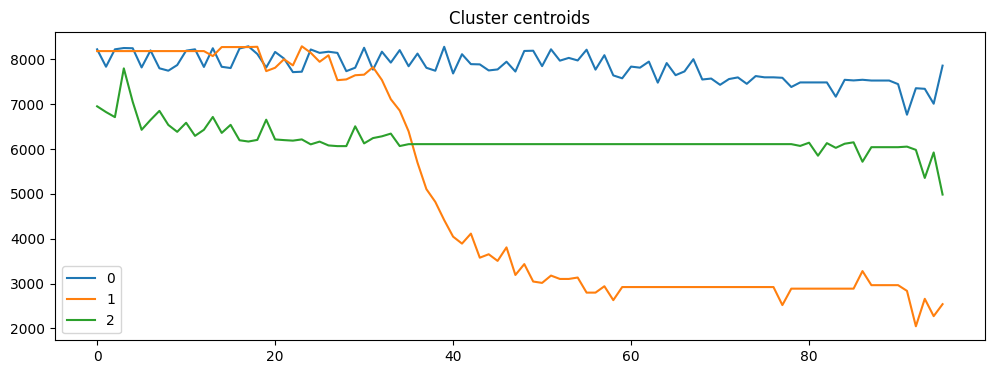

In [12]:
# Create a new figure with specified size
plt.figure(figsize=(12, 4))

# Iterate over each cluster
for cluster_number in range(n_clusters):
    # Plot the centroid of each cluster
    # The cluster centers are assumed to be 3D with shape (n_clusters, n_features, n_samples)
    # We're extracting the first feature across all samples for each cluster and plotting that
    plt.plot(model.cluster_centers_[cluster_number, :, 0].T, label=str(cluster_number))

# Set the title of the plot
plt.title("Cluster centroids")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

In [13]:
# The transpose operation is used to swap the rows and columns of 'data'.
df_transformed = data.T

# Use the trained model to predict the cluster for each instance in the dataset.
# The results are added as a new column 'cluster' in the dataframe.
df_transformed["cluster"] = model.predict(df_transformed)

# Convert the 'cluster' column into a dictionary.
# The keys in the dictionary are the index values from the dataframe,
# and the values in the dictionary are the corresponding values in the 'cluster' column.
d = dict(df_transformed["cluster"])

d

/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TimeSeriesKMeans or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming 

{'1': np.int64(0),
 '10': np.int64(2),
 '1a': np.int64(0),
 '1b': np.int64(0),
 '2': np.int64(2),
 '2a': np.int64(2),
 '3': np.int64(0),
 '3a': np.int64(2),
 '4': np.int64(0),
 '4a': np.int64(0),
 '5': np.int64(1),
 '5a': np.int64(1),
 '6': np.int64(0),
 '7': np.int64(1),
 '8': np.int64(0),
 '9': np.int64(2)}

In [16]:
# Map the 'well' column of the DataFrame 'df' to a new column 'cluster' using the dictionary 'd'
df["cluster"] = df["well"].map(d)

# Display the updated DataFrame 'df'
df

,date,well,qoil,qwat,qgas,bhp,cluster
0,2011-02-01,1,7946.07,34.68,NaN,2236.95,0
1,2011-03-04,1,8196.89,34.68,NaN,2236.95,0
2,2011-04-04,1,7888.97,34.68,NaN,2236.95,0
3,2011-05-05,1,8040.34,29.39,NaN,2236.95,0
4,2011-06-05,1,8206.16,9.31,NaN,2236.95,0
...,...,...,...,...,...,...,...
1531,2018-08-15,9,5379.18,1292.31,1714.38,1836.36,2
1532,2018-09-14,9,5182.23,1290.56,1709.96,1836.36,2
1533,2018-10-14,9,4850.04,1379.06,1825.66,1836.36,2
1534,2018-11-13,9,5184.44,1318.83,1862.73,1836.36,2


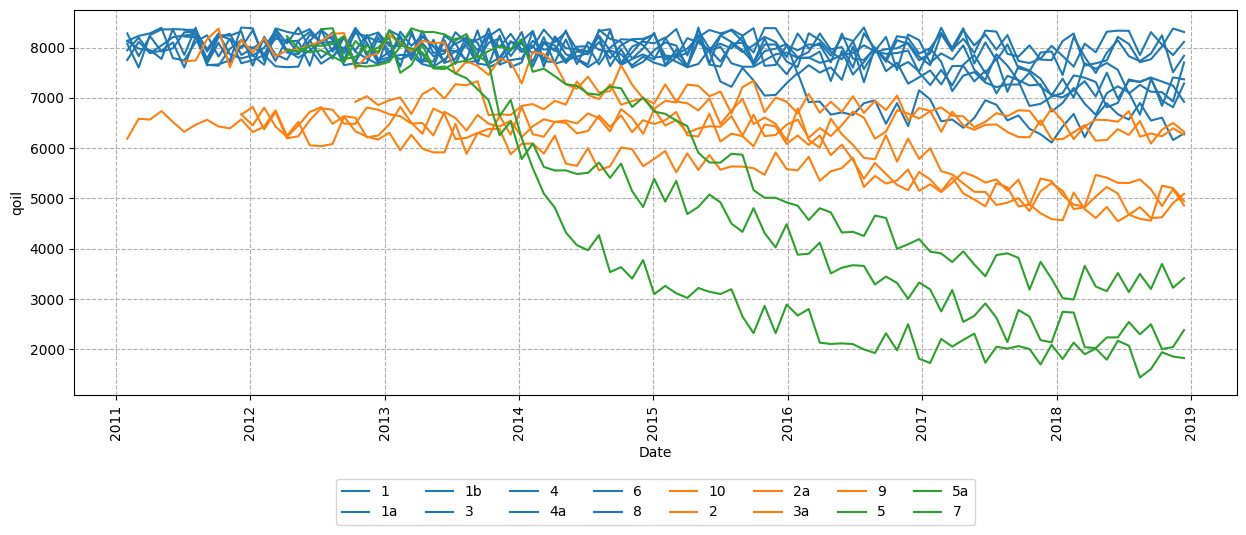

In [17]:
# Define a list of colors to be used for different clusters
color = ["C0", "C1", "C2", "C3"]

plt.figure(figsize=(15, 5))

# Iterate over each unique cluster in the DataFrame
for j, cluster in enumerate(df["cluster"].unique()):
    # Create a subset DataFrame for each cluster
    df_cluster = df[df["cluster"] == cluster]

    # Iterate over each unique well within the current cluster
    for i, well in enumerate(df_cluster["well"].unique()):
        df_well = df_cluster[df_cluster["well"] == well]

        # Plot the qoil over time for each well, assigning a unique color and label
        plt.plot(
            df_well["date"],
            df_well["qoil"],
            label=well,
            color=color[
                j % len(color)
            ],  # Use modulo operation to prevent index error if there are more clusters than colors
        )

# Set the legend at the specified location with a box around it
leg = plt.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, -0.2), ncol=8)

plt.grid(ls="--")

# Set the labels for the x and y axes
plt.xlabel("Date")
plt.ylabel("qoil")
plt.xticks(rotation=90)
plt.show()

/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/antonvoskresenskii/Yandex.Disk.localized/itmo/course/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


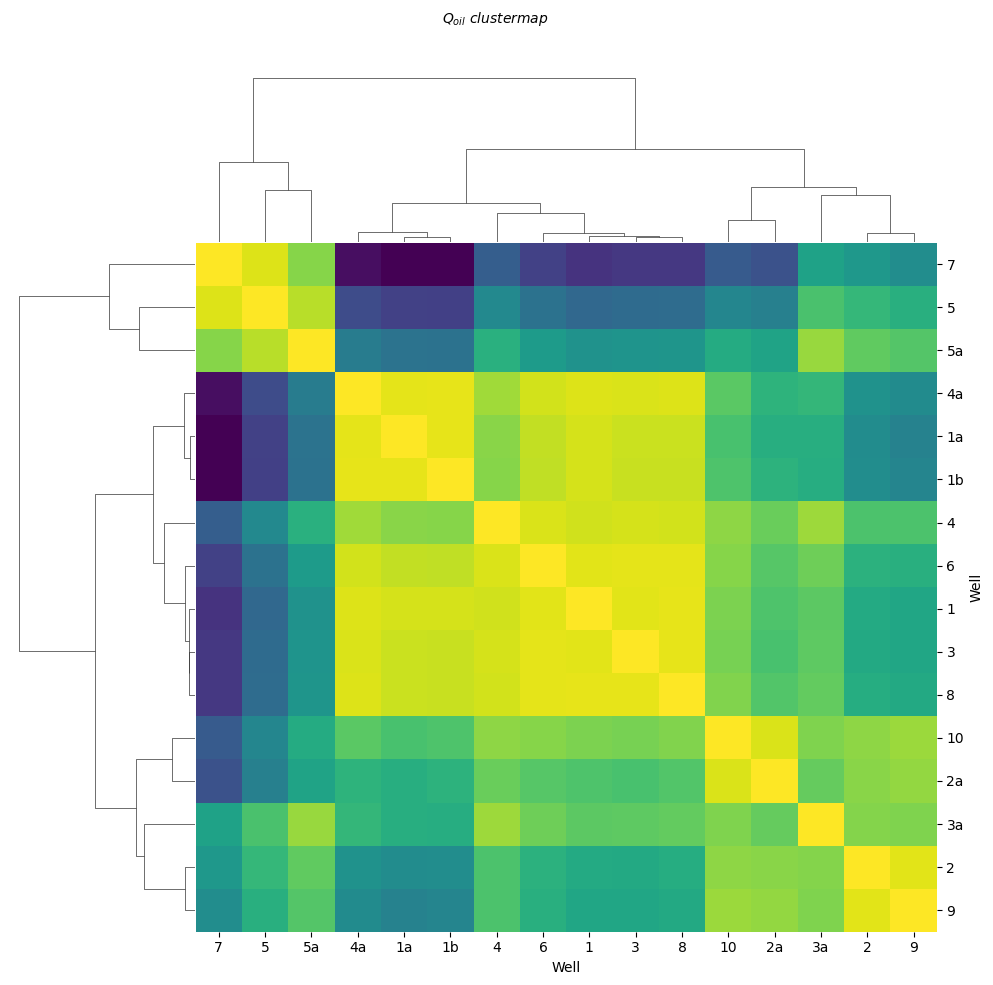

In [18]:
# Set the size for the labels on the plot
size = 10

# Transpose the original data and convert it to a numpy array
# This is done because the pdist function expects rows to represent observations (wells in this case)
# and columns to represent variables (time points in this case)
series = data.copy().T.to_numpy()

# Compute the pairwise distances between all wells using the Dynamic Time Warping (DTW) method
# DTW is a measure used to compute the distance between two temporal sequences, which may vary in speed
distances = pdist(series, dtw)

# Convert the condensed distance matrix returned by pdist into a square matrix
# and create a DataFrame using the well names as the row and column labels
distance_matrix = pd.DataFrame(
    data=squareform(distances), index=data.columns, columns=data.columns
)

# Create a clustermap (a type of heatmap) of the distance matrix
# viridis_r is a sequential colormap (reversed)
# cbar_pos=None removes the colorbar
cg = sns.clustermap(
    distance_matrix,
    cmap="viridis_r",
    cbar_pos=None,
)

cg.fig.suptitle(r"$Q_{oil}\ clustermap$", size=size)
plt.ylabel("Distance")
ax = cg.ax_heatmap
ax.set_xlabel("Well", size=size)
ax.set_ylabel("Well", size=size)
cg.fig.subplots_adjust(top=0.92)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Построение дендрограммы

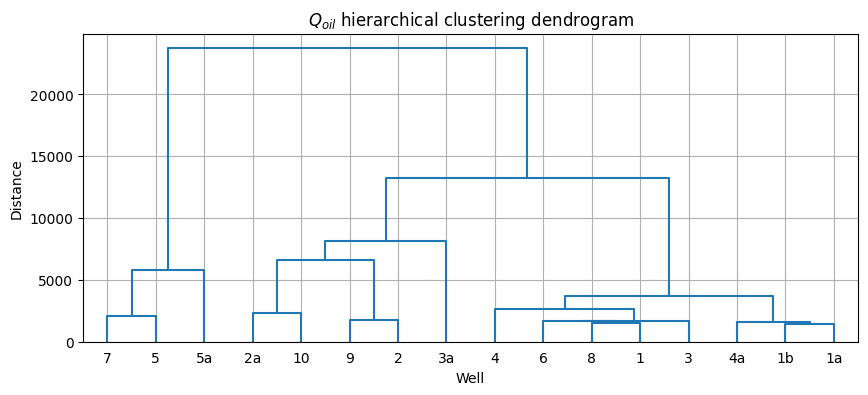

In [19]:
plt.figure(figsize=(10, 4))

# Perform hierarchical clustering using the linkage function
# distances: A precomputed matrix of distances between points (assumed to be provided)
# method="average": The linkage method to use. 'average' linkage computes the average distance between clusters
# metric="euclidean": The distance metric to use. In this case, Euclidean distance
# optimal_ordering=True: This reorders the linkage matrix so that the pairwise distances between successive leaves are minimal
links = linkage(distances, method="average", metric="euclidean", optimal_ordering=True)

plt.title(r"$Q_{oil}$" + " hierarchical clustering dendrogram")

plt.xlabel("Well", fontsize=10)
plt.ylabel("Distance")

# Generate the dendrogram plot
# links: The hierarchical clustering encoded as a linkage matrix
# color_threshold=2: The color threshold for the dendrogram. All the descendent links deeper than color_threshold are colored the same
# leaf_font_size=10: The font size for the leaf labels
# labels=data.columns: The labels for the leaves (assumed to be the columns of a DataFrame 'data')
# leaf_rotation=0: Rotates the leaf labels. Here, it's set to 0, so the labels are not rotated
dn = dendrogram(
    links, color_threshold=2, leaf_font_size=10, labels=data.columns, leaf_rotation=0
)

plt.grid()
plt.show()

- Совпадают ли ваши "экспертные" кластера с тем, что получилось путем кластеризации с помощью алгоритма DTW?
- Какие скважины не совпадают с вашей оценкой?
<br>
<br>
Создадим датафрейм с именем скажины и ее принадлежность к кластеру 

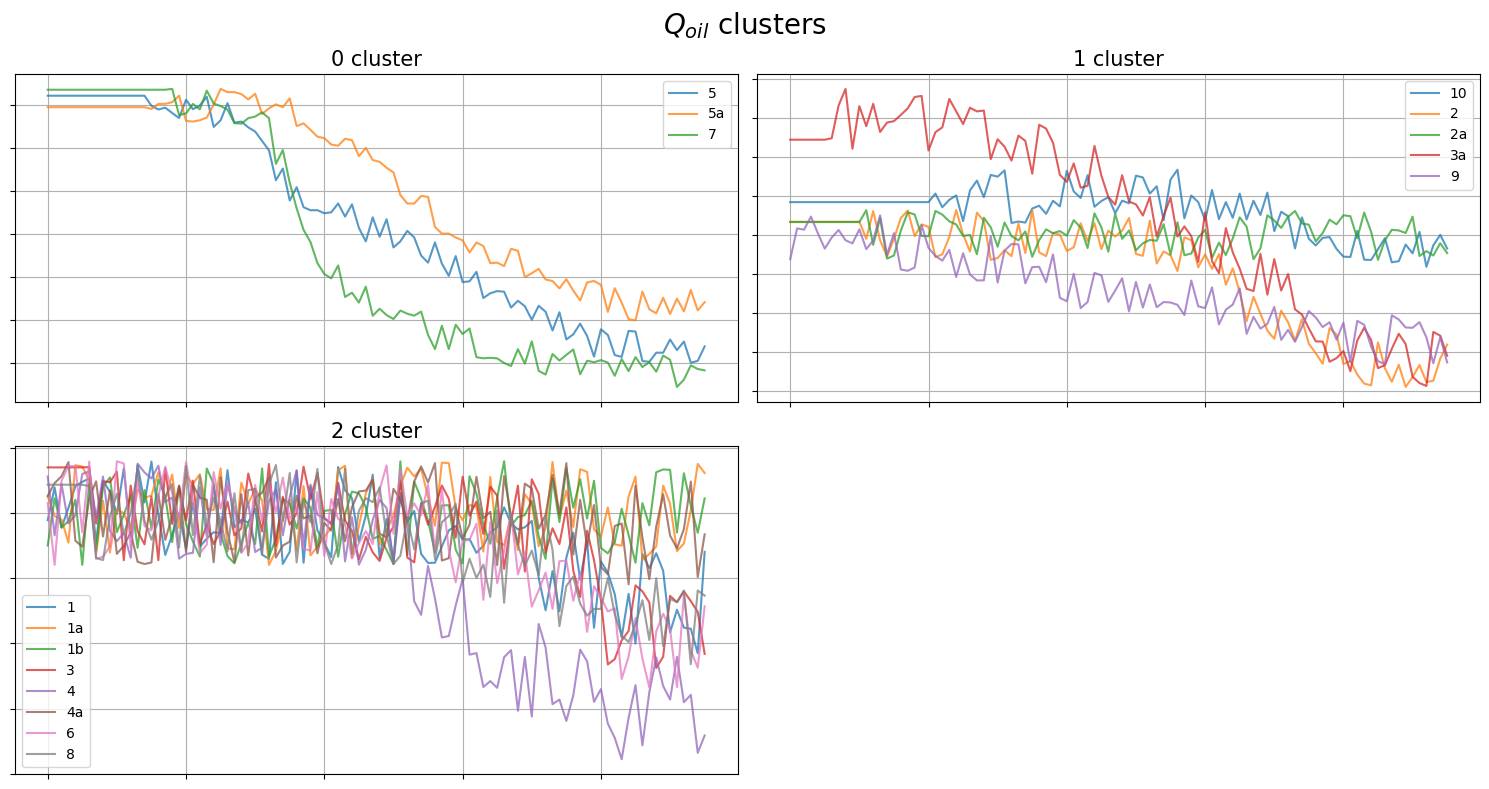

In [20]:
# List to store names of wells
well_names_list = np.asarray(data.columns)
# List to store the final well and cluster information
final_well_list = []
final_cluster_list = []


# Define function to visualize clusters
def visualize_clusters(
    series, links, num_clusters, num_series_to_draw=3, make_gray=False
):
    # Perform hierarchical clustering and get cluster assignments
    results = fcluster(links, num_clusters, criterion="maxclust")
    s = pd.Series(results)
    clusters = s.unique()

    # Determine the number of rows and columns for the plot
    ncols = 2
    nrows = np.ceil(len(clusters) / float(ncols)).astype(int)

    count = 0
    # Create subplots
    f, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
    for row in range(nrows):
        for col in range(ncols):
            ax = axs[row, col] if nrows > 1 else axs[col]
            cluster_idx = row * ncols + col
            if cluster_idx >= len(clusters):
                ax.axis("off")
                continue

            cluster_indices = s[s == cluster_idx + 1].index
            num_series_to_select = min(num_series_to_draw, len(cluster_indices))
            cluster_indices = np.random.choice(
                cluster_indices, num_series_to_select, replace=False
            )

            well_list = well_names_list[sorted(cluster_indices)].tolist()
            cluster_list = [count] * len(well_list)

            series_to_plot = series[sorted(cluster_indices), :]
            plt.suptitle(r"$Q_{oil}$" + " clusters", fontsize=20)

            for i, y in enumerate(series_to_plot):
                color = "gray" if make_gray else None
                ax.plot(y, color=color, alpha=0.75, label=well_list[i])
                ax.set_title(str(count) + " cluster", fontsize=15)
                ax.get_xaxis().set_ticklabels([])
                ax.get_yaxis().set_ticklabels([])

            final_well_list.extend(well_list)
            final_cluster_list.extend(cluster_list)
            count += 1
            ax.grid(True)
            ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)


# Number of clusters and series to draw
num_clusters = 3
num_series_to_draw = 100
make_gray = False

visualize_clusters(np.array(series), links, num_clusters, num_series_to_draw, make_gray)

Cluster number: 0


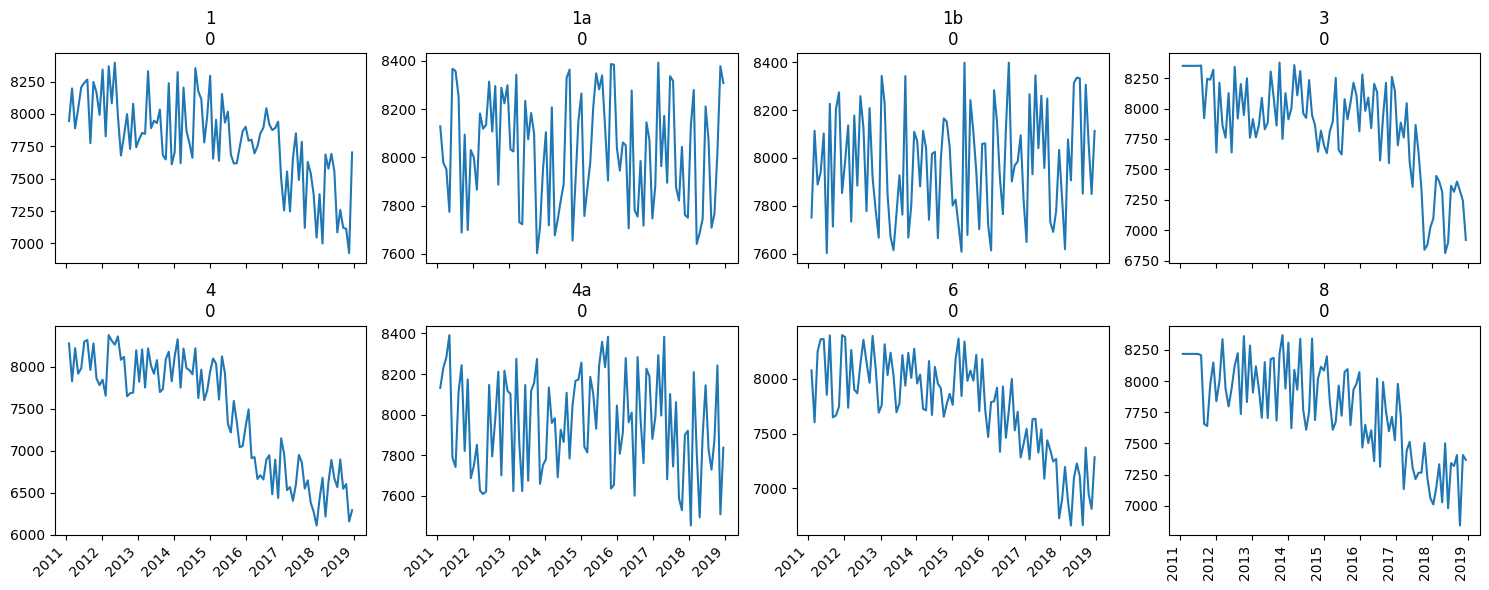

Cluster number: 1


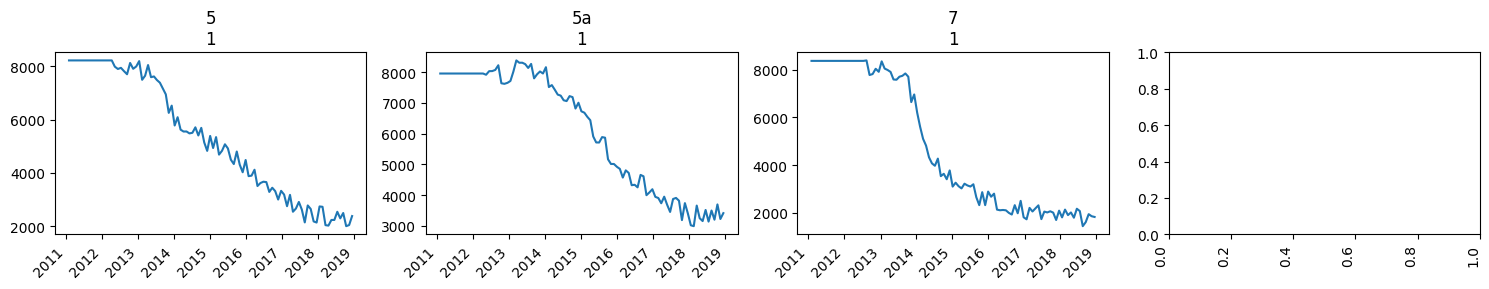

Cluster number: 2


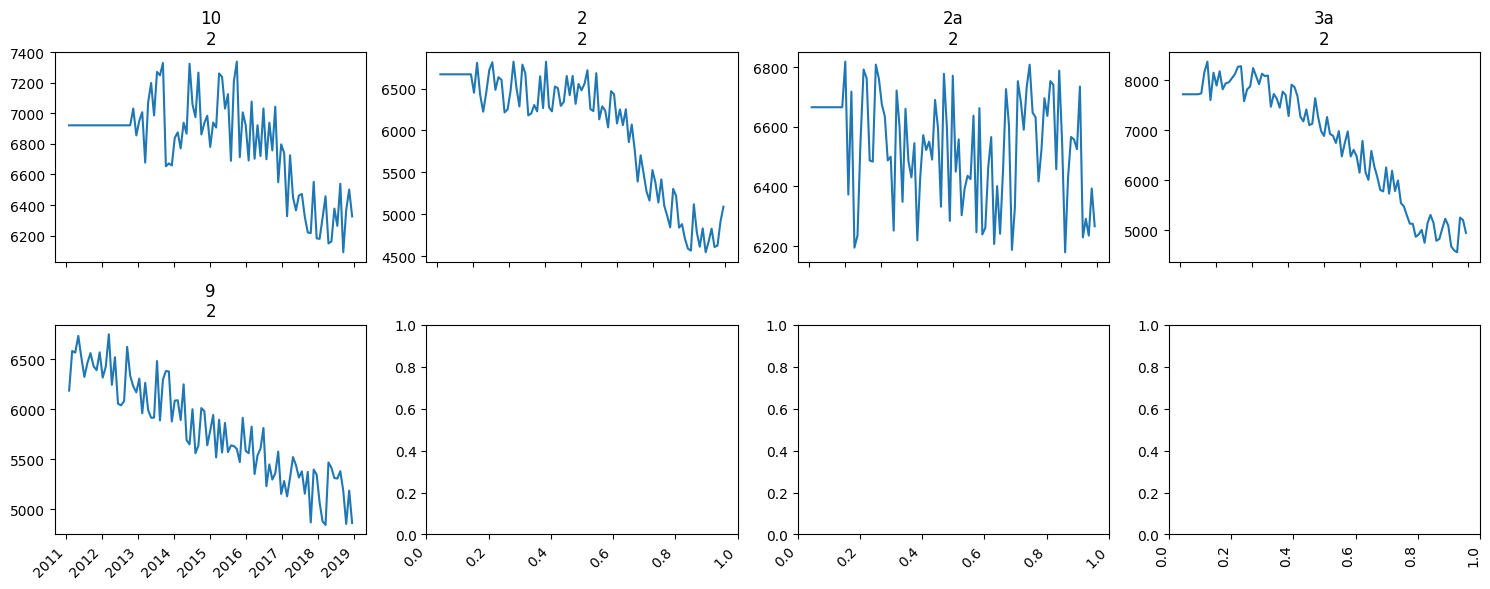

In [21]:
def plot_cluster_tickers(current_cluster):
    # The number of subplots is determined by the number of rows in the current_cluster dataframe.
    # The layout is arranged in a 4-column grid, with the number of rows determined by dividing the number of data points by 4 and rounding up.
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0] / 4)),
        4,
        figsize=(
            15,
            3 * int(np.ceil(current_cluster.shape[0] / 4)),
        ),  # The figure size is determined by the number of subplots
    )
    fig.autofmt_xdate(
        rotation=45
    )  # Rotates the x-axis labels 45 degrees for better visibility

    # Reshape the axis object to a 1D array, so we can iterate over it
    ax = ax.reshape(-1)

    # Iterate over the rows of the dataframe
    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(
            row.iloc[1:-1]
        )  # Plot the row data, excluding the first and last columns
        ax[index].set_title(
            f"{row.well}\n{row.cluster}"
        )  # Set the title for each subplot
        plt.xticks(
            rotation=90
        )  # Rotate the x-axis labels 90 degrees for better visibility

    plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
    plt.show()  # Display the figure


# Iterate over the clusters
for cluster in range(n_clusters):
    print(f"Cluster number: {cluster}")
    # For each cluster, filter the dataframe for rows that belong to the current cluster, reset the index, and plot the tickers
    plot_cluster_tickers(
        df_transformed[df_transformed.cluster == cluster].reset_index()
    )

In [ ]:
df_transformed

In [22]:
# Reset the index of the DataFrame `df_transformed`
# After resetting, the index becomes a new column in the DataFrame
df_transformed_reset = df_transformed.reset_index()

# Select the "well" and "cluster" columns from the DataFrame `df_transformed_reset`
wells_and_clusters = df_transformed_reset[["well", "cluster"]]
wells_and_clusters

date,well,cluster
0,1,0
1,10,2
2,1a,0
3,1b,0
4,2,2
5,2a,2
6,3,0
7,3a,2
8,4,0
9,4a,0


Визуализуруем полученные профили добычи

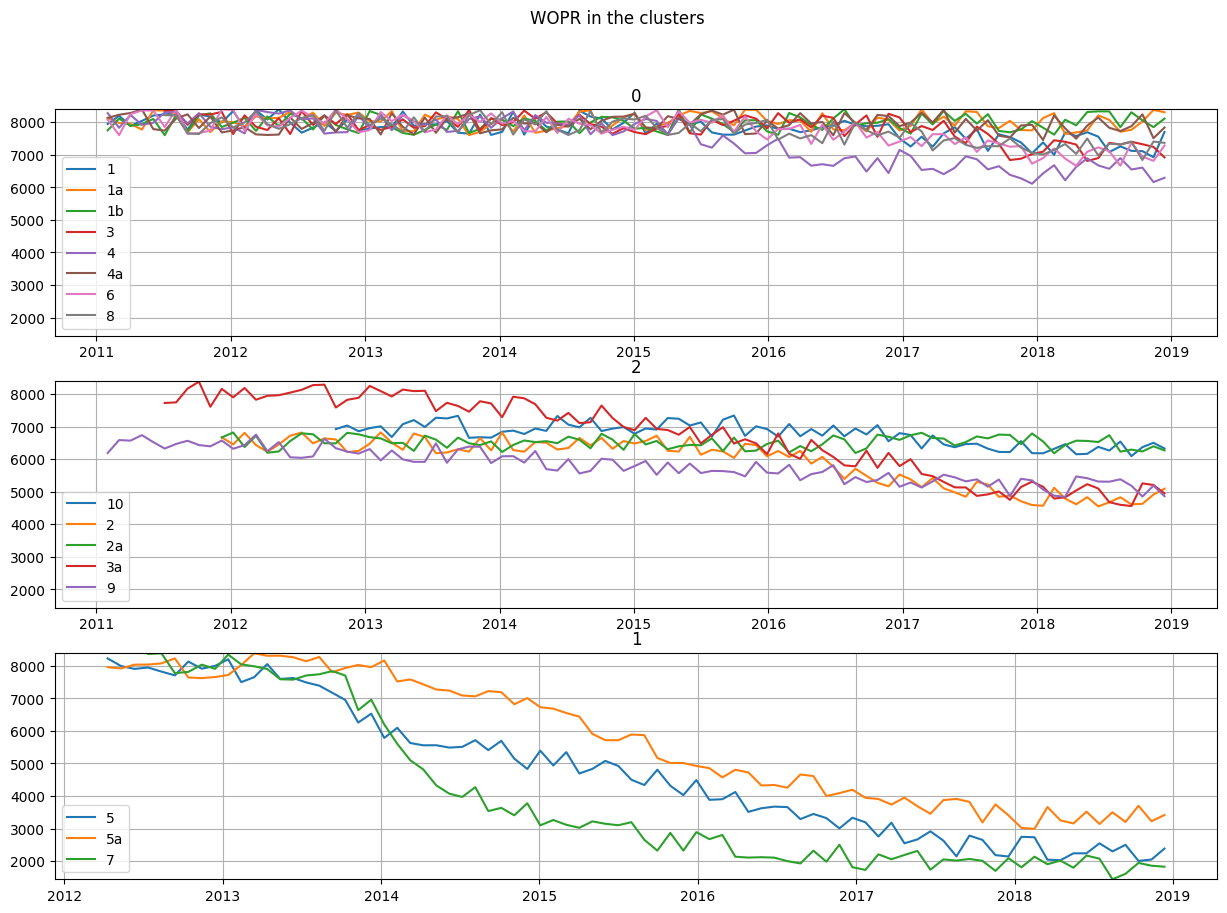

In [24]:
ymin = df[column].min()
ymax = df[column].max()

plt.figure(figsize=(15, 10))
plt.suptitle("WOPR in the clusters")

# Define the number of rows and columns for subplots
nrows = 3
ncols = 1

index = 1

for cluster in wells_and_clusters["cluster"].unique():
    # Iterate over the unique well values within each cluster
    for well in wells_and_clusters[wells_and_clusters["cluster"] == cluster][
        "well"
    ].unique():
        # Add a subplot at the current index
        plt.subplot(nrows, ncols, index)

        # Plot the data for the current well
        well_data = df[df["well"] == well]
        plt.plot(well_data["date"], well_data[column], label=well)

        # Set the y-axis limits
        plt.ylim(ymin, ymax)

    plt.title(cluster)
    plt.legend(loc="lower left")
    plt.grid()

    # Increment the subplot index
    index += 1

- Какие скважины выбиваются из общего паттерна кластера?

Загрузим датафрейм с ккординатами скважин

In [25]:
# Set the path to the data file
path = "data/"

# Read the excel file into a pandas DataFrame
data = pd.read_excel(f"{path}coordinates.xlsx")

# Convert the 'well' column to string
# This is necessary if the column contains non-string values
data["well"] = data["well"].astype("str")

# Convert all the string values in the 'well' column to lower case
# This ensures consistency in case comparison
data["well"] = data["well"].str.lower()

# Display the DataFrame
data

,X,Y,well
0,1332664,283884,4a
1,1332664,283283,6
2,1315608,285360,8
3,1311508,280276,10
4,1333457,288754,9
5,1304242,283920,7
6,1309252,285269,5
7,1309235,284290,5a
8,1316093,282728,2
9,1316093,281726,2a


In [26]:
wells_and_clusters["well"] = wells_and_clusters["well"].astype(str)

wells_and_clusters

/var/folders/vx/d70k_j2d49q255qhb_42b9h80000gn/T/ipykernel_34354/2023423283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wells_and_clusters["well"] = wells_and_clusters["well"].astype(str)


date,well,cluster
0,1,0
1,10,2
2,1a,0
3,1b,0
4,2,2
5,2a,2
6,3,0
7,3a,2
8,4,0
9,4a,0


Объединим 2 датафрейма на колнку 'Well'

In [27]:
data = data.merge(wells_and_clusters, on="well", how="left")
data

,X,Y,well,cluster
0,1332664,283884,4a,0
1,1332664,283283,6,0
2,1315608,285360,8,0
3,1311508,280276,10,2
4,1333457,288754,9,2
5,1304242,283920,7,1
6,1309252,285269,5,1
7,1309235,284290,5a,1
8,1316093,282728,2,2
9,1316093,281726,2a,2


Визуализируем карту с полученными кластерами

In [28]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map

    Parameters
    ----------
    N : int
        The number of colors needed in the colormap.
    base_cmap : str, optional
        The base colormap to use. This should be a name of a colormap recognized by matplotlib.

    Returns
    -------
    newmap : Colormap
        A new colormap with N colors spanning the range of base_cmap.
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : scipy.spatial.Voronoi instance
        The input Voronoi diagram.
    radius : float, optional
        The distance to 'points at infinity'. If not provided, the maximum point-to-point
        distance within the input points is used.

    Returns
    -------
    regions : list of lists
        A list of regions of the Voronoi diagram. Each region is a list of indices of the
        Voronoi vertices forming the region.
    vertices : ndarray
        The coordinates of the Voronoi vertices.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points, axis=0).max() * 2

    # Rest of the function remains unchanged
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]  # Tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # Normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

/var/folders/vx/d70k_j2d49q255qhb_42b9h80000gn/T/ipykernel_34354/3829851327.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


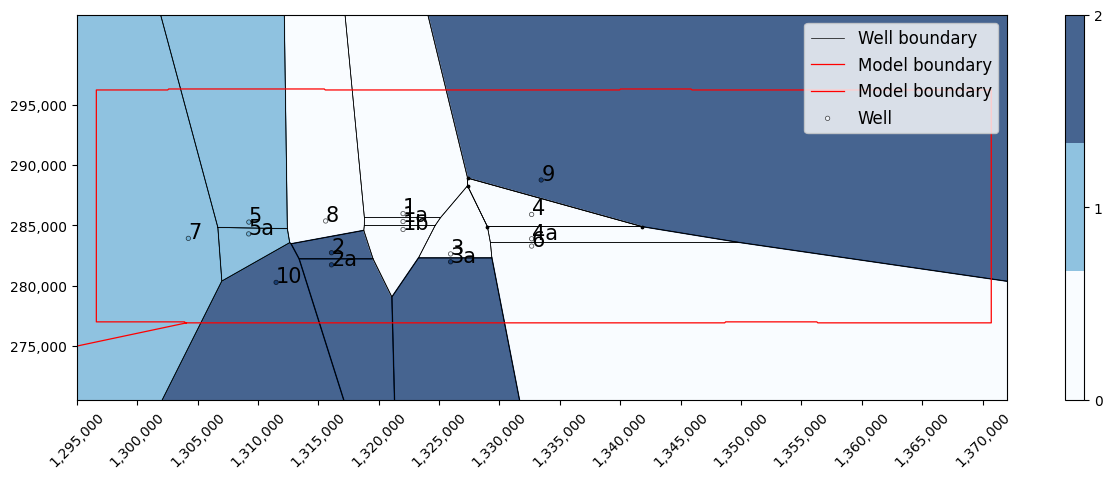

In [29]:
# Create a figure and axes for the plot
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Determine the number of unique clusters in the data
number_of_clusters = len(data["cluster"].unique())

# Get the X and Y coordinates of each point in the data
coordinates = np.array(data[["X", "Y"]])
points = coordinates

# Compute Voronoi diagram of the points
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Find min/max values for normalization
minima = min(data["cluster"])
maxima = max(data["cluster"])

# Normalize chosen colormap
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)

# Plot borders and fill of Voronoi cells
count = 0
for i in regions:
    points = vertices[i]
    x = points[:, 0]
    y = points[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, "k", linewidth=0.5)
    plt.fill(*zip(*points), alpha=0.75, color=mapper.to_rgba(data["cluster"][count]))
    count += 1

plt.plot(x, y, "k", linewidth=0.5, label="Well boundary")


# Plot well locations
plt.scatter(points[:, 0], points[:, 1], color="black", s=3)

# Read polygon boundary data from a file
with open("data/boundary", "r") as file:
    polygon_boundary = np.array([list(map(float, line.split())) for line in file])

# Plot model boundary
plt.plot(*polygon_boundary.T, color="red", linewidth=0.9, label="Model boundary")

# Plot data points with color coded clusters
plt.scatter(
    data.X,
    data.Y,
    cmap=discrete_cmap(number_of_clusters, "Blues"),
    c=data["cluster"],
    marker="o",
    lw=0.5,
    edgecolors="black",
    s=10,
    alpha=0.75,
    label="Well",
)

# Annotate data points with their corresponding labels
for label, x, y in zip(data["well"], data["X"], data["Y"]):
    plt.annotate(label, xy=(x, y), size=15)

# Set plot limits and tick values
plt.axis("equal")
plt.xlim(1295000, 1372000)
plt.ylim(275000, 298000)
plt.yticks(np.arange(275000, 298000, 5000))
plt.xticks(np.arange(1295000, 1372000, 5000))

# Format the tick labels on the x and y axis
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

plt.xticks(rotation=45)

# Add a colorbar to the plot
plt.colorbar(ticks=range(number_of_clusters))

legend = plt.legend(loc="upper right", shadow=False, fontsize="large")
legend.get_frame()
plt.show()

Задание:
- Прокластеризуйте временные ряды датасета СOSTA (https://www.researchgate.net/publication/358582459_The_Design_of_an_Open-Source_Carbonate_Reservoir_Model, https://www.researchgate.net/publication/358903422_An_Open_Access_Carbonate_Reservoir_Model, https://researchportal.hw.ac.uk/en/datasets/costa-model-hierarchical-carbonate-reservoir-benchmarking-case-st) используя подхъходящий метод. Вы не ограничены DTW. Можете, например, представить одно или многомерный сигнал как разложение Фурье или набор признаков (TSFresh)
- Попробуйте определить оптимальное количество кластеров. Какой метод оценки вы выбрали для этого типа данных и почему?
- Визуализируйте кластера на карте
- Как пространственно меняются кластера по площади месторождения?
- Какой метод кластеризации выдает наиболее устойчивый результат при использовании данных различной природы?
- Какой метод выдает объекты кластеров которые наиболее сосредоточены рядом друг с другом на карте? Как можно количественно оценить это?